![title](https://storage.googleapis.com/kaggle-competitions/kaggle/4853/media/home_depot_tools.jpg)

This data set contains a number of products and real customer search terms from Home Depot's website. The challenge is to predict a relevance score for the provided combinations of search terms and products. To create the ground truth labels, Home Depot has crowdsourced the search/product pairs to multiple human raters.

The relevance is a number between 1 (not relevant) to 3 (highly relevant). For example, a search for "AA battery" would be considered highly relevant to a pack of size AA batteries (relevance = 3), mildly relevant to a cordless drill battery (relevance = 2), and not relevant to a snow shovel (relevance = 1).

Each pair was evaluated by at least three human raters. The provided relevance scores are the average value of the ratings. There are three additional things to know about the ratings:

* The specific instructions given to the raters is provided in relevance_instructions.docx.
* Raters did not have access to the attributes.
* Raters had access to product images, while the competition does not include images.

Your task is to predict the relevance for each pair listed in the test set. Note that the test set contains both seen and unseen search terms.

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("ggplot")

import matplotlib
matplotlib.rc("font", family = "AppleGothic")
matplotlib.rc("axes", unicode_minus = False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as os

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

pd.options.display.max_columns = 5000
pd.options.display.max_rows = 1000

## File descriptions


* train.csv - the training set, contains products, searches, and relevance scores
* test.csv - the test set, contains products and searches. You must predict the relevance for these pairs.
* product_descriptions.csv - contains a text description of each product. You may join this table to the training or test set via the product_uid.
* attributes.csv -  provides extended information about a subset of the products (typically representing detailed technical specifications). Not every product will have attributes.
* sample_submission.csv - a file showing the correct submission format
relevance_instructions.docx - the instructions provided to human raters

In [2]:
train = pd.read_csv("Desktop/phthon/Kaggle/homedepot/train.csv", encoding = "ISO-8859-1", index_col= "id")
print(train.shape)
train.head(2)

(74067, 4)


,product_uid,product_title,search_term,relevance
id,,,,
2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.0
3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.5


In [3]:
test = pd.read_csv("Desktop/phthon/Kaggle/homedepot/test.csv", encoding = "ISO-8859-1", index_col= "id")
print(test.shape)
test.head(2)

(166693, 3)


,product_uid,product_title,search_term
id,,,
1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets


In [4]:
descriptions=pd.read_csv("Desktop/phthon/Kaggle/homedepot/product_descriptions.csv")
print(descriptions.shape)
descriptions.head(2)

(124428, 2)


,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...


In [5]:
attributes=pd.read_csv("Desktop/phthon/Kaggle/homedepot/attributes.csv")
print(attributes.shape)
attributes.head()

(2044803, 3)


,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


# preprocessing

###  merge

In [6]:
# product_description이 후에 필요한 정보로 사용될 가능성이 높음으로 merge를 해준다

train = train.merge(descriptions, on = "product_uid", how = "left")
test = test.merge(descriptions, on = "product_uid", how = "left")
print(train.shape)
print(test.shape)

(74067, 5)
(166693, 4)


In [7]:
# attributes같은 경우 경우의 수가 많은 것을 보이나, 실제로는 brand name 즉 이름이 있다 이를 뽑아서 merge를 시켜준다 

attributes_name = attributes.loc[attributes["name"] == "MFG Brand Name"]
attributes_name = attributes_name[["product_uid", "value"]]

train = train.merge(attributes_name, on = "product_uid", how = "left")
test = test.merge(attributes_name, on = "product_uid", how = "left")

# 별도작업 진행

In [8]:
# 혼동 방지를 위해서 순서를 test와 동일하게 해놓는다 

train = train[['product_uid', 'product_title', 'search_term', 'product_description','value','relevance']]
train.head()

,product_uid,product_title,search_term,product_description,value,relevance
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,3.00
1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,2.50
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,3.00
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,Update your bathroom with the Delta Vero Singl...,Delta,2.33
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,Update your bathroom with the Delta Vero Singl...,Delta,2.67


In [9]:
test.head()

,product_uid,product_title,search_term,product_description,value
0,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
1,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
2,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
3,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie
4,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie


## 1)product_uid

In [10]:
# train과 test의 product_uid 중복여부를 조사해본다
## 중복되지 않은 넘버를 별도처리하거나 다르게 처리해야할 방법을 생각해본다
print(len(train["product_uid"].unique()))
print(len(test["product_uid"].unique()))

54667
97460


In [11]:
# 중복되는경우는 27699건이나 현 문제의 경우 product_uid의 존재여부의 중요성 보단 상품의 검색여부를 따저봐야하는 것이기 때문에 
# product_uid만 따로 발라내는 것은 하지 않는다 

# 다만 product_uid가 중복되지 않은 수가 상당하다는것은 유념하고 있어야 한다 
len(set(train["product_uid"]) & set(test["product_uid"].unique()))

27699

## 2)relevance report

In [12]:
# relevance가 3인 경우와 0인 경우를 비교분석해본다
relevance_3 = train.loc[train["relevance"] == 3]
relevance_1 = train.loc[train["relevance"] == 1]

In [13]:
# 분석결과 search_term이 product_title 혹은 product_description과 검색어가 똑같다면(대소문자 상관없이) 검색결과가 높이 나오는 경향이 있다 
# 양쪽 모두에 단어가 있으면 거의 대부분 3에 가까운 숫자가 되는것이라는 점도 알 수 있다 
# 그렇기 때문에 이들간의 상관관계를 이용해서 relevance를 유추하는 것이 가능해진다

relevance_3.head()

,product_uid,product_title,search_term,product_description,value,relevance
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,3.0
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,3.0
5,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,Achieving delicious results is almost effortle...,Whirlpool,3.0
7,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,microwaves,Achieving delicious results is almost effortle...,Whirlpool,3.0
9,100009,House of Fara 3/4 in. x 3 in. x 8 ft. MDF Flut...,mdf 3/4,Get the House of Fara 3/4 in. x 3 in. x 8 ft. ...,House of Fara,3.0


In [14]:
# 반대로 search_term이 product_title 혹은 product_description과의 연관성이 낮다면, 검색 관계성이 매우 낮게 나온다 

# 주목할 점은 230번과 같이 face masks로서 제품인 mask와 단어유사성이 있음에도 완전히 다른 제품이라 관계성이 1인 경우다 
# 이 경우는 후에 별도 처리를 하거나 / 아니면 그 수가 미미함으로 확률상 낮기 때문에 없는 것으로 간주를 한다 
relevance_1.head()

,product_uid,product_title,search_term,product_description,value,relevance
17,100017,MD Building Products 36 in. x 36 in. Cloverlea...,door guards,The MD Building Products 36 in. x 36 in. x 1/5...,MD Building Products,1.0
49,100033,HDX 48 in. W x 72 in. H x 18 in. D Decorative ...,kitchen cabinet finishes,This easy-to-assemble Decorative Wire Chrome F...,HDX,1.0
56,100034,Marshalltown Masonry Brush,mortar tools,Use the Marshalltown Masonry Brush for a wide ...,Marshalltown,1.0
217,100119,Purdy 2 in. A. P. All Paints Brush Set (3-Pack),paint roller inserts,"The Purdy 1 in. Angled, 1-1/2 in. Angled, 2 in...",Purdy,1.0
226,100128,Proslat 32 sq. ft. White Wall Panel Kit,garage chair organizer,This Proslat wall solution features Proslat's ...,Proslat,1.0


**나아갈 방향**

* search_term, product_title, product_description 3개의 컬럼의 단어를 동일하게 적용해서 
* 대소문자를 전부 소문자로 / 뒤에 -ed, 혹은 s와 같은 부분을 없애주고 적용한다  

## 3)word union(통합)

In [16]:
# 대소문자를 소문자로 통합하고 단어를 통일성있게 만들고자 snowball을 사용한다 

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
stemmer.stem

<bound method EnglishStemmer.stem of <EnglishStemmer>>

In [17]:
# 확인결과 제대로 작동이 안된다 -> product로 바뀌지 않았음
[stemmer.stem("BEHR Premium Textured DeckOver")]

['behr premium textured deckov']

In [18]:
train["value"].unique()

array(['Simpson Strong-Tie', 'BEHR Premium Textured DeckOver', 'Delta',
       ..., 'United Solutions', '3M Tekk Protection', 'Plastec'],
      dtype=object)

In [19]:
# 이 snowballstemmer는 띄어쓰기를 고려하지 않아서 전체문장중에서 맨 마지막 단어만 바꿔주는 문제가 있기때문에 별도로 처리를 진행해준다 

def changeword(term):
    return " ".join(stemmer.stem(word) for word in term.lower().split())

# 바꾸려는 부분 train, test에 전부 적용한다  
train["product_title(fix)"] = train["product_title"].apply(changeword)
train["search_term(fix)"] = train["search_term"].apply(changeword)
train["product_description(fix)"] = train["product_description"].apply(changeword)

In [20]:
test["product_title(fix)"] = test["product_title"].apply(changeword)
test["search_term(fix)"] = test["search_term"].apply(changeword)
test["product_description(fix)"] = test["product_description"].apply(changeword)

In [21]:
# 이렇게 해도 되고 / astype("str")로 가도 상관없지만, 나중에 분석 시 NAN부분을 따로 발라내서 보기편하게 대문자 X로 해놓는다

def changeword2(term):
    if pd.isnull(term):
        return "X"
    else:
        return " ".join(stemmer.stem(word) for word in term.split(" "))

train["value(fix)"] = train["value"].apply(changeword2)
test["value(fix)"] = test["value"].apply(changeword2)
#train["value"].value_counts

In [22]:
(test.loc[test["value(fix)"] == "X"]).head()

,product_uid,product_title,search_term,product_description,value,product_title(fix),search_term(fix),product_description(fix),value(fix)
664,100160,DEWALT 20-Volt Max Lithium-Ion Cordless Combo ...,20v dewalt kombo,The DEWALT DCK940D2 combo kit is ideal for jus...,NaN,dewalt 20-volt max lithium-ion cordless combo ...,20v dewalt kombo,the dewalt dck940d2 combo kit is ideal for jus...,X
665,100160,DEWALT 20-Volt Max Lithium-Ion Cordless Combo ...,dewalt 20v,The DEWALT DCK940D2 combo kit is ideal for jus...,NaN,dewalt 20-volt max lithium-ion cordless combo ...,dewalt 20v,the dewalt dck940d2 combo kit is ideal for jus...,X
666,100160,DEWALT 20-Volt Max Lithium-Ion Cordless Combo ...,dewalt combo kits,The DEWALT DCK940D2 combo kit is ideal for jus...,NaN,dewalt 20-volt max lithium-ion cordless combo ...,dewalt combo kit,the dewalt dck940d2 combo kit is ideal for jus...,X
667,100160,DEWALT 20-Volt Max Lithium-Ion Cordless Combo ...,dewalt tool kits,The DEWALT DCK940D2 combo kit is ideal for jus...,NaN,dewalt 20-volt max lithium-ion cordless combo ...,dewalt tool kit,the dewalt dck940d2 combo kit is ideal for jus...,X
668,100160,DEWALT 20-Volt Max Lithium-Ion Cordless Combo ...,mke 7pc combo kit,The DEWALT DCK940D2 combo kit is ideal for jus...,NaN,dewalt 20-volt max lithium-ion cordless combo ...,mke 7pc combo kit,the dewalt dck940d2 combo kit is ideal for jus...,X


In [23]:
test.head()

,product_uid,product_title,search_term,product_description,value,product_title(fix),search_term(fix),product_description(fix),value(fix)
0,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,simpson strong-ti 12-gaug angl,90 degre bracket,"not onli do angl make joint stronger, they als...",simpson strong-ti
1,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,simpson strong-ti 12-gaug angl,metal l bracket,"not onli do angl make joint stronger, they als...",simpson strong-ti
2,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,simpson strong-ti 12-gaug angl,simpson sku abl,"not onli do angl make joint stronger, they als...",simpson strong-ti
3,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,simpson strong-ti 12-gaug angl,simpson strong tie,"not onli do angl make joint stronger, they als...",simpson strong-ti
4,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,simpson strong-ti 12-gaug angl,simpson strong tie hcc668,"not onli do angl make joint stronger, they als...",simpson strong-ti


## 4)word 합치기 

각각의 단어에 순서를 매기는걸 생각해봣는데 그건 여기에 어울리지 않는다 그 방법은 한 열의 글자의 중복을 방지하기 위해 하는 것인데 이건 각 셀에서 일치하는 단어여부 - 그니까 서치의 정확성 여부를 판단하는 문제이기 때문이다 

-> 그래서 각 term이 다른2개에 얼마나 많이 중복이 되는지 여부를 반드시 파악해야함을 알아야한다

In [24]:
# 컬럼의 변수들을 합친다
# 기준으로 삼아야할것(여기서는 term임 term이 나머지 두개에 포함이 되냐 마냐를 따질수 있음) -> 가장 앞으로 놔둔다
# 단어의 위치구분을 위해 합칠 때 "/t"사용한다

train["term_title_description"] = train["search_term(fix)"] + "\t" + train["product_title(fix)"] + "\t" \
+ train["product_description(fix)"] + "\t" + train["value(fix)"]

test["term_title_description"] = test["search_term(fix)"] + "\t" + test["product_title(fix)"] + "\t" \
+ test["product_description(fix)"] + "\t" + test["value(fix)"]

## 5)search_term 갯수 구하기

In [25]:
# term의 단어수가 중요하다고 본다. 거기서 3개의 단어를 검색했는데 3개가 다 나머지 변수에 있다면 그건 그만큼 3에 가까운 점수가 될 수 있을 것이다

# 단어 갯수를 별도의 컬럼으로 빼온다
train["search_term(int)"] = train["search_term(fix)"].map(lambda x: len(x.split(" ")))
test["search_term(int)"] = test["search_term(fix)"].map(lambda x: len(x.split(" ")))

In [26]:
# 마찬가지로 나머지도 전부 len을 이용하여 단어의 개수를 나오게 한다 
train["product_description(int)"] = train["product_description(fix)"].map(lambda x: len(x.split(" ")))
test["product_description(int)"] = test["product_description(fix)"].map(lambda x: len(x.split(" ")))

train["product_title(int)"] = train["product_title(fix)"].map(lambda x: len(x.split(" ")))
test["product_title(int)"] = test["product_title(fix)"].map(lambda x: len(x.split(" ")))

train["value(int)"] = train["value(fix)"].map(lambda x: len(x.split(" ")))
test["value(int)"] = test["value(fix)"].map(lambda x: len(x.split(" ")))

In [27]:
train.head()

,product_uid,product_title,search_term,product_description,value,relevance,product_title(fix),search_term(fix),product_description(fix),value(fix),term_title_description,search_term(int),product_description(int),product_title(int),value(int)
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,3.00,simpson strong-ti 12-gaug angl,angl bracket,"not onli do angl make joint stronger, they als...",simpson strong-ti,angl bracket\tsimpson strong-ti 12-gaug angl\t...,2,129,4,2
1,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,2.50,simpson strong-ti 12-gaug angl,l bracket,"not onli do angl make joint stronger, they als...",simpson strong-ti,l bracket\tsimpson strong-ti 12-gaug angl\tnot...,2,129,4,2
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,3.00,behr premium textur deckov 1-gal. #sc-141 tugb...,deck over,behr premium textur deckov is an innov solid c...,behr premium textur deckov,deck over\tbehr premium textur deckov 1-gal. #...,2,167,11,4
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,Update your bathroom with the Delta Vero Singl...,Delta,2.33,delta vero 1-handl shower onli faucet trim kit...,rain shower head,updat your bathroom with the delta vero single...,delta,rain shower head\tdelta vero 1-handl shower on...,3,104,13,1
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,Update your bathroom with the Delta Vero Singl...,Delta,2.67,delta vero 1-handl shower onli faucet trim kit...,shower onli faucet,updat your bathroom with the delta vero single...,delta,shower onli faucet\tdelta vero 1-handl shower ...,3,104,13,1


## 6)일치여부(coincidence) 찾기

#합친 후 서로 중복되는 단어가 몇개인지 분석한다 
#필요한 부분들을 전부 도출한다 
#특히 필요한 것은 검색한 단어와 기타의 중복수 -> 검색을 했을 때 title, brandname, description이 얼마나 잘 나오나
#또 브랜드네임과 기타의 연관성이다 -> 검색과 연결된 title, description가 brandname을 이끌어주는건가의 문제임


In [28]:
def coincidence1(term):
    return sum(int(term.split("\t")[1].find(word)>=0) for word in term.split("\t")[0].split())

def coincidence2(term):
    return sum(int(term.split("\t")[2].find(word)>=0) for word in term.split("\t")[0].split())

def coincidence3(term):
    return sum(int(term.split("\t")[-1].find(word)>=0) for word in term.split("\t")[0].split())

def coincidence4(term):
    return sum(int(term.split("\t")[1].find(word)>=0) for word in term.split("\t")[-1].split())

def coincidence5(term):
    return sum(int(term.split("\t")[2].find(word)>=0) for word in term.split("\t")[-1].split())

# def coincidence6(term):
#     return sum(int(term.split("\t")[2].find(word)>=0) for word in term.split("\t")[1].split())

# train과 test에 적용
train["term_title"] = train["term_title_description"].apply(coincidence1)
train["term_description"] = train["term_title_description"].apply(coincidence2)
train["term_vlaue"] = train["term_title_description"].apply(coincidence3)
train["name_title"] = train["term_title_description"].apply(coincidence4)
train["name_description"] = train["term_title_description"].apply(coincidence5)
#  train["title_description"] = train["term_title_description"].apply(coincidence6)

test["term_title"] = test["term_title_description"].apply(coincidence1)
test["term_description"] = test["term_title_description"].apply(coincidence2)
test["term_vlaue"] = test["term_title_description"].apply(coincidence3)
test["name_title"] = test["term_title_description"].apply(coincidence4)
test["name_description"] = test["term_title_description"].apply(coincidence5)
#  test["title_description"] = test["term_title_description"].apply(coincidence6)

# Explotory

* Each pair was evaluated by at least three human raters.   - 최소3명이상 평가함
* The provided relevance scores are the average value of the ratings. - 그래서 평균을 냄
* There are three additional things to know about the ratings:
* The specific in structions given to the raters is provided in relevance_instructions.docx. 이 워드 봐야한다는것
* Raters did not have access to the attributes.   - 특성파트는 보지 않았다 / 중요한 자료는 아니라는 이야기임
* Raters had access to product images, while the competition does not include images. - 이미지를 보았다는것/ 여기에는 없다
* Your task is to predict the relevance for each pair listed in the test set. 
* Note that the test set contains both seen and unseen search terms. - 서치용어가 보이는것과 보이지 않는게 있다 
* Brand, Material, and Functionality / Brand is as important as the Functionality

In [29]:
# 먼저 분석해봤을 때 먼저 term_title / term_description이 둘다 0이면 -> relevance가 1일 가능성이 높을 것이다라는 가정에 분석해본다

term_zero = train.loc[(train["term_title"] == 0) & (train["term_description"] == 0)]
#term_zero["relevance"].value_counts(normalize = True)
term_zero["relevance"].value_counts(normalize = True)

# 확인결과 이 가정은 옳지 않다는 사실이 나옴 / 오히려 1보다 2쪽에 훨씬 가까웠다
# 이 이야기는 이러한 방식으로 하는것이 아닌 / 전체적인 윤곽을 봐야하는 것을 의미한다고 생각했다

2.33    0.200762
1.67    0.169402
2.00    0.164127
2.67    0.138628
1.00    0.128370
3.00    0.100821
1.33    0.095545
2.50    0.000586
1.50    0.000586
2.25    0.000293
2.75    0.000293
1.75    0.000293
1.25    0.000293
Name: relevance, dtype: float64

## 1) 분석결과

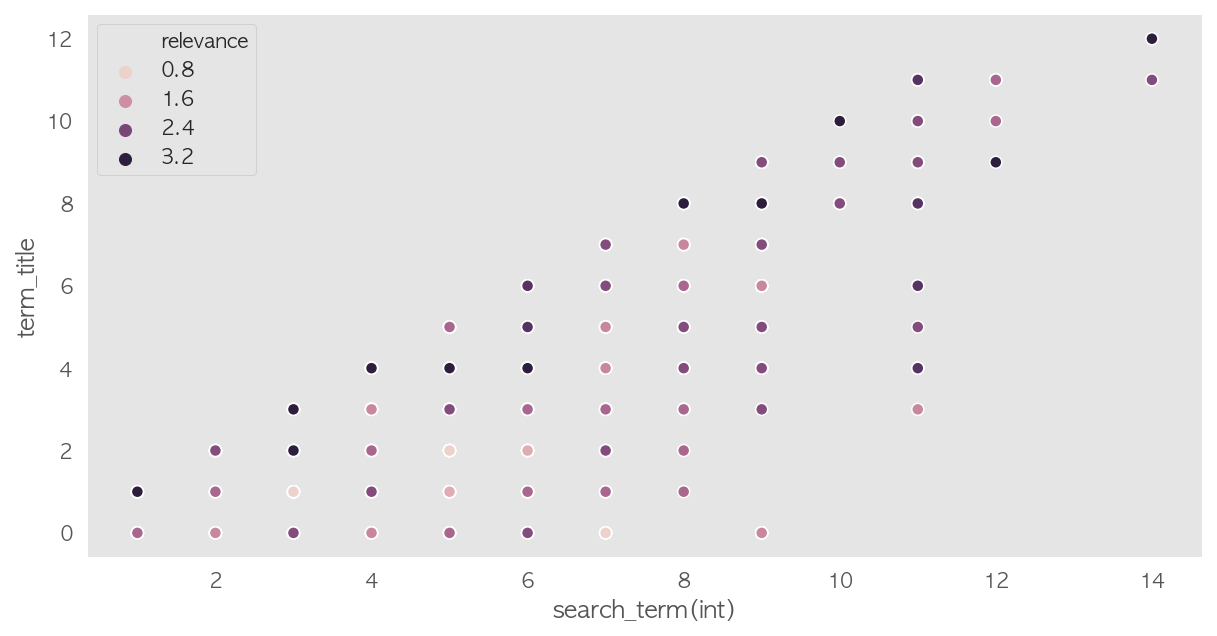

In [30]:
# 같은 검색수일 경우 그만큼 정확성이 높아질 가능성이 높다

plt.figure(figsize = [10,5])
plt.grid(False)
sns.scatterplot(x = "search_term(int)", y = "term_title", data= train, hue = "relevance", sizes = (30,450))

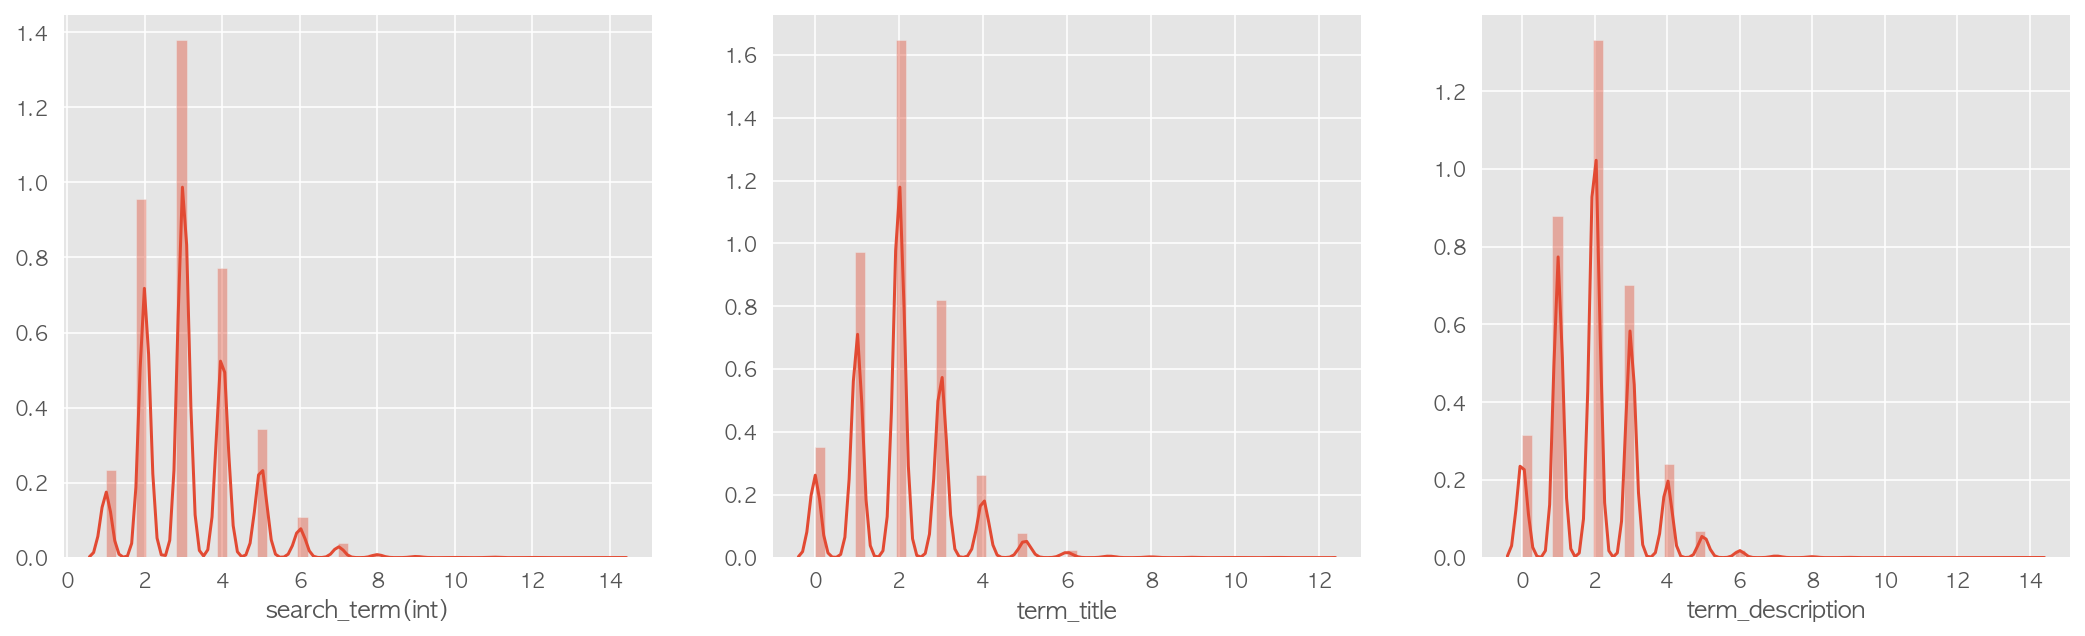

In [31]:
# 먼저 구해진 각 수를 통해 정도의 차이를 분석해본 결과
# 큰 차이 없이 3개가 비슷하게 가고있음 -> 이곳에서는 차별성을 느낄 수 없기에 다른 방향으로 진행하기로 함
fig = plt.figure(figsize = [18,5])
ax1 = fig.add_subplot(1,3,1)
ax1 = sns.distplot(train["search_term(int)"])

ax1 = fig.add_subplot(1,3,2)
ax1 = sns.distplot(train["term_title"])

ax1 = fig.add_subplot(1,3,3)
ax1 = sns.distplot(train["term_description"])

(0.0, 8.0)

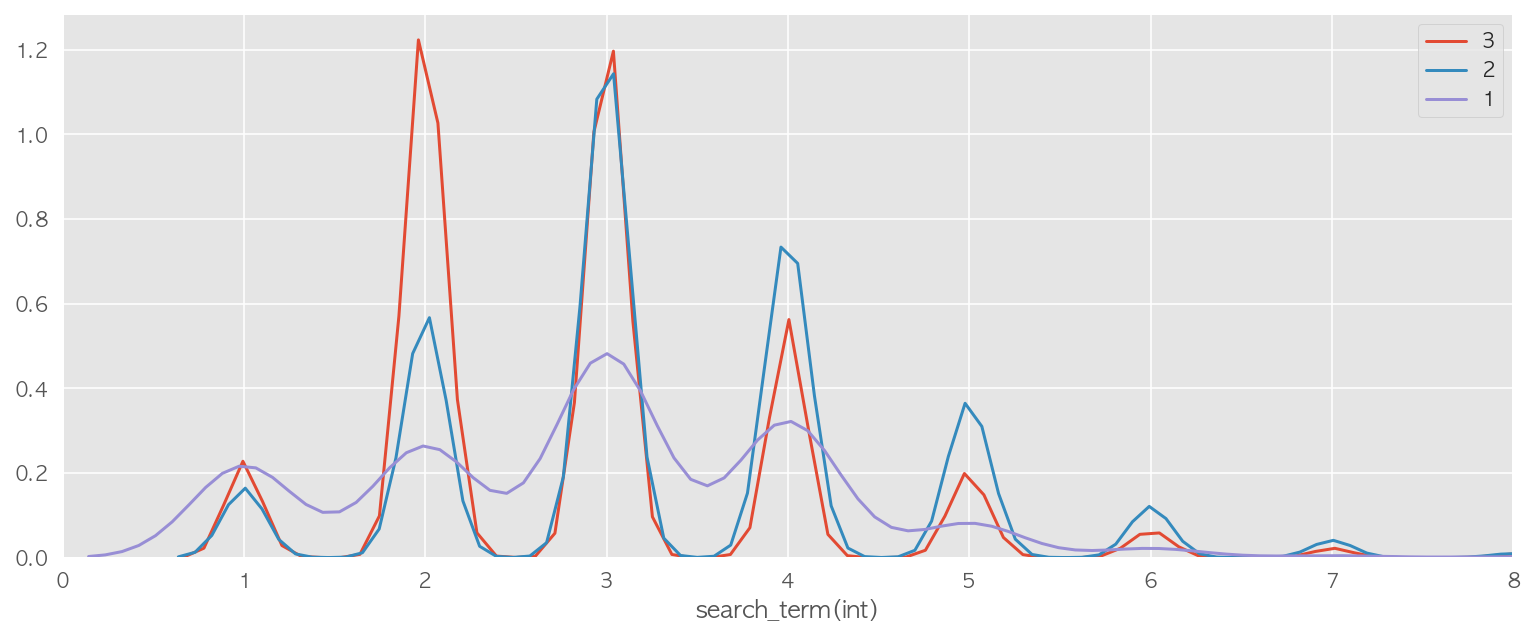

In [32]:
# 별도로 relevance를 나누어서 진행하여 시각화 시킨결과
# search_term(int)이 2,3인 경우가 정확성이 가장 높다는 점을 발견
# 이를 좀더 자세히 보기로 한다 

relevance3 = train.loc[train["relevance"] == 3]
relevance2 = train.loc[train["relevance"] == 2]
relevance1 = train.loc[train["relevance"] == 1]

plt.figure(figsize = [13,5])
ax1 = sns.distplot(relevance3["search_term(int)"], hist = False, label = "3")
ax1 =sns.distplot(relevance2["search_term(int)"], hist = False, label = "2")
ax1 =sns.distplot(relevance1["search_term(int)"], hist = False, label = "1")
ax1.set_xlim(0,8)

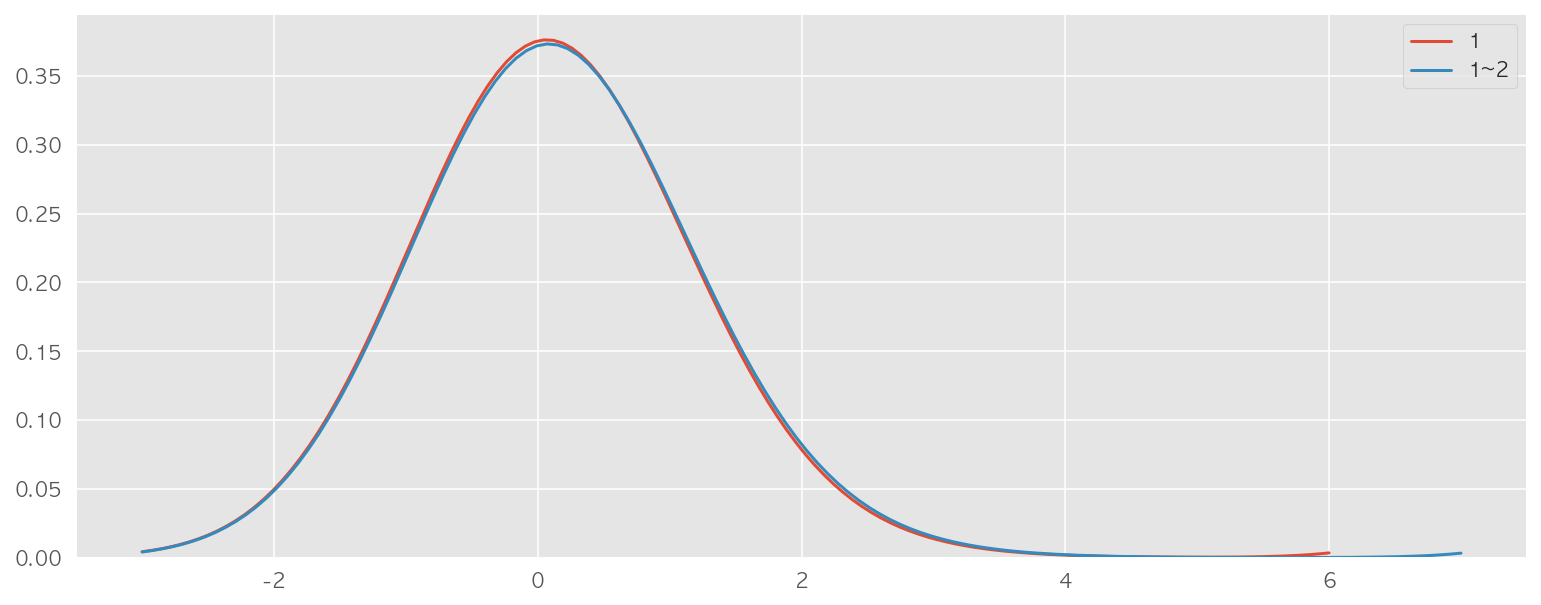

In [68]:
# term_vlaue 즉 검색어와 브랜드네임의 상관관계를 조사해보았을때 신기한 점을 발견하였음
# relevance가 1인 경우 그러니까 가장 점수가 낮은 경우 term_vlaue가 2인 경우의 수가 조금 더 많다는 것임 
# 2, 3은 거의 비슷한 그래프를 보이고 있지만 1에서 약간의 차이가 발생한다 


# 따라서 train["relevance"]가 2인 것을 별도로 처리해줄 필요가 있음 
relevance3 = train.loc[train["relevance"] == 3]
relevance2 = train.loc[train["relevance"] == 2]
relevance1 = train.loc[train["relevance"] == 1]
relevance1_2 = train.loc[train["relevance"] < 2]

plt.figure(figsize = [13,5])
# ax1 =sns.distplot(relevance3["term_vlaue"], hist = False, label = "3")
# ax1 =sns.distplot(relevance2["term_vlaue"], hist = False, label = "2")
ax1 =sns.kdeplot(relevance1["term_vlaue"],  bw = 1, label = "1")
ax1 =sns.kdeplot(relevance1_2["term_vlaue"],  bw = 1, label = "1~2")

## 2) 검색수(search_term(int)) 

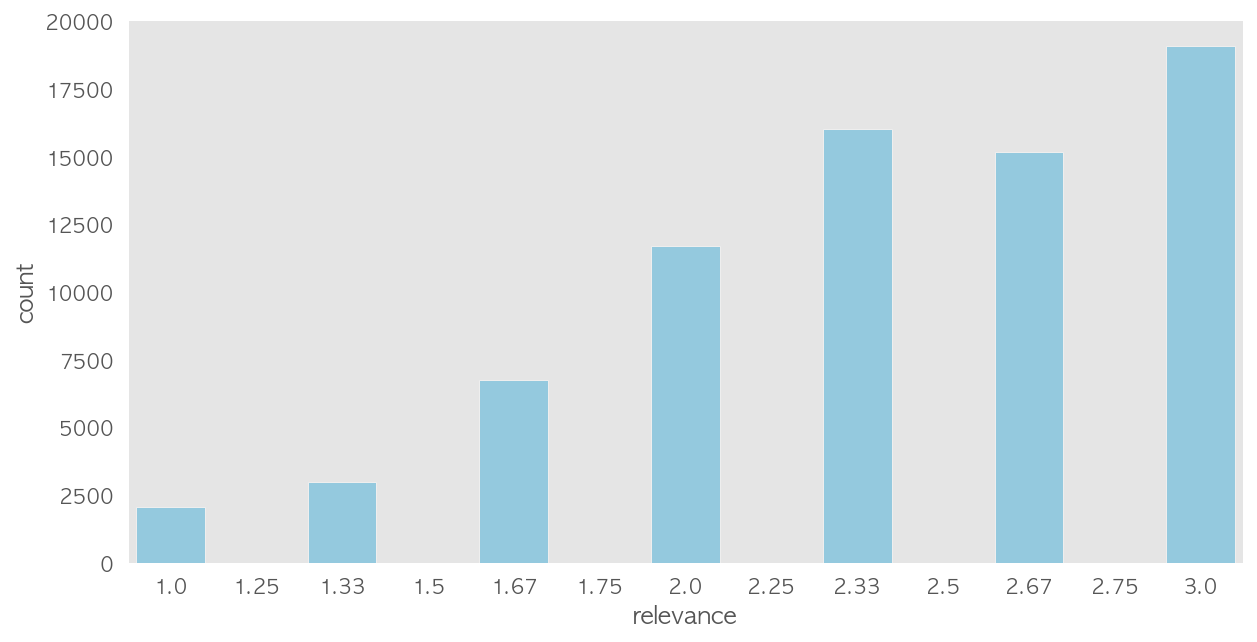

In [36]:
plt.figure(figsize = [10,5])
plt.grid(False)
sns.countplot(x = "relevance", data = train, color = "skyblue")

피벗테이블로 서치개수(search_term(int))에 따른 relevance영향력 측정결과 몇가지 주목해야할 점을 발견했다 

1)
* 검색수가 8개 이상 넘어가는 것은 대부분 2.0 이상으로 구성되어있다. 이는 그만큼 검색을 많이하면 그 연관검색어도 많이 검색이 된다는 점에서 기인한다고 본다
* 따라서 9개 검색 이상인 경우 2.0이상으로 간주를 해서 범위를 좁힌다 

2)
* 검색수가 2,3인 것에 역시 주목할 필요가 있음. 1.5를 기준으로 중상정도로 평가를 한다면 2,3개의 검색어가 잘 맞춰지는 경우 대부분 긍정적인 결과를 낳았다고 
* 이해할 수 있을 것이다. homedepot의 검색부분에 있어서 2~3, 혹은 4개정도까지의 검색이 최적회되어있음을 보여주고 있음과 동시에 
* 고객들이 가장 많은 검색을 하는 갯수가 이 부분에 있음을 의미하기도 한다 
* 이 부분을 좀더 개선한다면 더 만족한 결과를 보여줄 수도 있고 더 많은 고객들이 만족을 느낄 수 있을 것으로 분석된다
* 또한 이부분을 좀더 파고들어 새로운 인사이트를 발견할 필요가 있다 

3)
* 1.25 / 1.5 / 1.75 / 2.25 / 2.5 / 2.75의 절대적인 수치가 매우 적다 
* 이는 계산을 하는데 큰 메리트가 되지 않으니 train으로 정하지 않고 범위를 좁힌다

In [37]:
pd.pivot_table(index = "search_term(int)", columns = "relevance", values = "term_description", data = train,\
              aggfunc = len)

relevance,1.00,1.25,1.33,1.50,1.67,1.75,2.00,2.25,2.33,2.50,2.67,2.75,3.00
search_term(int),,,,,,,,,,,,,
1,329.0,1.0,251.0,1.0,585.0,NaN,567.0,NaN,920.0,2.0,737.0,1.0,1109.0
2,397.0,NaN,520.0,1.0,1301.0,NaN,2057.0,NaN,3370.0,6.0,3819.0,1.0,6914.0
3,724.0,2.0,1147.0,1.0,2523.0,4.0,4366.0,8.0,5673.0,7.0,5347.0,5.0,6768.0
4,487.0,NaN,722.0,NaN,1519.0,3.0,2802.0,2.0,3489.0,3.0,3074.0,4.0,2742.0
5,123.0,1.0,272.0,2.0,597.0,1.0,1323.0,1.0,1730.0,NaN,1485.0,NaN,1066.0
6,33.0,NaN,63.0,NaN,163.0,NaN,418.0,NaN,579.0,1.0,471.0,NaN,348.0
7,7.0,NaN,25.0,NaN,71.0,NaN,141.0,NaN,195.0,NaN,190.0,NaN,112.0
8,3.0,NaN,5.0,NaN,16.0,1.0,35.0,NaN,58.0,NaN,44.0,NaN,42.0
9,1.0,NaN,NaN,NaN,3.0,NaN,13.0,NaN,26.0,NaN,22.0,NaN,15.0


In [38]:
test["search_term(int)"].value_counts()

3     56420
2     51329
4     28100
1     12772
5     12004
6      4004
7      1241
8       469
9       145
10      104
12       54
11       46
14        4
13        1
Name: search_term(int), dtype: int64

## 2) search_term True/False

In [39]:
# 서치개수(search_term(int))가 2,3, 4 인경우 relevance가 3인 경우가 많기에 별도로 분석해서 상관관계를 분석해본다

train2and3 = train.loc[(train["search_term(int)"] == 2) |(train["search_term(int)"] == 3)]

pd.pivot_table(index = ["search_term(int)","term_title"], columns = "relevance",values = "product_uid",\
               data = train2and3, aggfunc = ["count"])

pd.pivot_table(index = ["search_term(int)","term_description"], columns = "relevance",values = "product_uid",\
               data = train2and3, aggfunc = ["count"])
# 분석 결과 
# search_term(int) 2,3번의 경우 search_term(int)과 동일한 경우 그 값이 매우 강하게 보인다 
# 이들만 따로 분리해서 적용시켜준다 

count                                \
relevance                           1.00 1.25   1.33 1.50    1.67 1.75   
search_term(int) term_description                                        
2                0                 154.0  NaN  143.0  NaN   282.0  NaN   
                 1                 168.0  NaN  249.0  1.0   626.0  NaN   
                 2                  75.0  NaN  128.0  NaN   393.0  NaN   
3                0                  96.0  NaN  121.0  NaN   250.0  2.0   
                 1                 255.0  2.0  369.0  NaN   742.0  NaN   
                 2                 341.0  NaN  579.0  1.0  1309.0  1.0   
                 3                  32.0  NaN   78.0  NaN   222.0  1.0   

                                                                          \
relevance                            2.00 2.25    2.33 2.50    2.67 2.75   
search_term(int) term_description                                          
2                0                  362.0  NaN   491.0  2.0   438.0  NaN   
                 1                  976.0  NaN  1454.0  4.0  1563.0  NaN   
                 2                  719.0  NaN  1425.0  NaN  1818.0  1.0   
3                0                  310.0  2.0   300.0  NaN   215.0  NaN   
                 1                 1216.0  2.0  1374.0  1.0  1073.0  NaN   
                 2                 2289.0  4.0  2912.0  5.0  2519.0  3.0   
                 3                  551.0  NaN  1087.0  1.0  1540.0  2.0   

                                           
relevance                            3.00  
search_term(int) term_description          
2                0                  462.0  
                 1                 2410.0  
                 2                 4042.0  
3                0                  157.0  
                 1                  849.0  
                 2                 2563.0  
                 3                 3199.0

In [40]:
# search_term(int) 2,3인 수들만 땨로 True / False로 바꾸어서 개별작업을 해준다 

def number2(x):
    if (x["search_term(int)"] == 2) and (x["search_term(int)"] == x["term_title"]):
        return True
    if (x["search_term(int)"] == 2) and (x["search_term(int)"] == x["term_description"]):
        return True
    if (x["search_term(int)"] == 3) and (x["search_term(int)"] == x["term_title"]):
        return True
    if (x["search_term(int)"] == 3) and (x["search_term(int)"] == x["term_description"]):
        return True
    else:
        return False


#     if (x["search_term(int)"] == 4) and (x["search_term(int)"] == x["term_title"]):
#         return True
#     if (x["search_term(int)"] == 4) and (x["search_term(int)"] == x["term_description"]):
#         return True
#     if (x["search_term(int)"] == 5) and (x["search_term(int)"] == x["term_title"]):
#         return True
#     if (x["search_term(int)"] == 5) and (x["search_term(int)"] == x["term_description"]):
#         return True
    
#     else:
#         return False
    
    
# xxx = { "search_term(int)" : 3,
#       "term_title" : 2,
#       "term_description" : 2}
#number2(xxx)
    
    
train["number"] = train.apply(number2, axis = "columns")
test["number"] = test.apply(number2, axis = "columns")

In [41]:
test["search_term(int)"].value_counts()

3     56420
2     51329
4     28100
1     12772
5     12004
6      4004
7      1241
8       469
9       145
10      104
12       54
11       46
14        4
13        1
Name: search_term(int), dtype: int64

## 3) 변수제거

In [42]:
# 1.25 / 1.5 / 1.75 / 2.25 / 2.5 / 2.75의 절대적인 수치가 매우 적음으로 효율성 측면에서 제거하는게 좋을듯함

def number3(x):
    if x in [1.25, 1.5, 1.75, 2.25, 2.5, 2.75]:
        return False
    else:
        return True
    
train["false_true"] = train["relevance"].apply(number3)

In [43]:
# train을 활용하고 train3인 것은 버린다

train = train[train["false_true"] == True]
train3 = train[~train["false_true"] == True]

print(train.shape)

(74008, 22)


# 4) brand name 건 파악

In [44]:
# 위에서 코딩을 할 때 brandname, 즉 value(fix)가 nan인 경우가 있었고 이를  X로 처리를 했다
# 이 brandname이 어떠한지를 살펴보아 인사이트를 도출해본다
train_X = train.loc[train["value(fix)"] == "X"]
train_X["relevance"].value_counts()
train_X.head()

,product_uid,product_title,search_term,product_description,value,relevance,product_title(fix),search_term(fix),product_description(fix),value(fix),term_title_description,search_term(int),product_description(int),product_title(int),value(int),term_title,term_description,term_vlaue,name_title,name_description,number,false_true
198,100109,Shark Navigator Lift-Away Deluxe Bagless Vacuu...,shark cleaner,A lightweight and steerable Never Loses Suctio...,NaN,3.0,shark navig lift-away delux bagless vacuum cle...,shark cleaner,a lightweight and steerabl never lose suction ...,X,shark cleaner\tshark navig lift-away delux bag...,2,164,10,1,2,0,0,0,0,True,True
199,100109,Shark Navigator Lift-Away Deluxe Bagless Vacuu...,shark vacuum,A lightweight and steerable Never Loses Suctio...,NaN,3.0,shark navig lift-away delux bagless vacuum cle...,shark vacuum,a lightweight and steerabl never lose suction ...,X,shark vacuum\tshark navig lift-away delux bagl...,2,164,10,1,2,1,0,0,0,True,True
219,100124,"Champion Power Equipment 3,100 Watt Gasoline P...",inverter generator,The Champion Power Equipment 16590 gasoline po...,NaN,3.0,"champion power equip 3,100 watt gasolin power ...",invert generat,the champion power equip 16590 gasolin powered...,X,"invert generat\tchampion power equip 3,100 wat...",2,183,15,1,2,2,0,0,0,True,True
302,100160,DEWALT 20-Volt Max Lithium-Ion Cordless Combo ...,dewalt combo kit,The DEWALT DCK940D2 combo kit is ideal for jus...,NaN,3.0,dewalt 20-volt max lithium-ion cordless combo ...,dewalt combo kit,the dewalt dck940d2 combo kit is ideal for jus...,X,dewalt combo kit\tdewalt 20-volt max lithium-i...,3,228,8,1,3,3,0,0,0,True,True
578,100329,5-Step Pressure-Treated Cedar-Tone Pine Stair ...,stair steps,Get head starts building outdoor stairs with t...,NaN,3.0,5-step pressure-tr cedar-ton pine stair stringer,stair step,get head start build outdoor stair with this d...,X,stair step\t5-step pressure-tr cedar-ton pine ...,2,147,6,1,2,1,0,0,0,True,True


위 결과 다음과 같음을 알 수 있었다
* 1) 고객은 브랜드네임을 잘 몰랐고 또 검색어는 브랜드네임과 직접적인 연관성이 없었다. 그럼에도 불구하고 이것이 만족하는 3의로 나왔다는 것은 검색과 관련이 있는 search_term과 product_description이 브랜드네임을 올바르게 이끌어주었다는 이야기이다
* 2) 그렇기 때문에 이 데이터는 매우 중요한 데이터라는 점이기에 데이터를 추출할 때 brandname과의 연관성이 있는 부분들을 반드시 변수로 넣어줘야 한다
* 3) 또한 위 확인 결과 search_term(int) term_title term_description 이 3가지의 숫자가 같은 경우 3이 나오는 경우가 많고 꼭 3이 아니더라도 높은 점수가 나오는 가능성이 높기에 이부분을 별도로 처리해준다 


In [45]:

# 이 경우 별로로 처리를 해주지는 않는다 / 이미 이것은 term title등에 반영이 되어있기 때문에 제외한다 

# def number5(x):
    
#     if (x["value(fix)"] == "X") and (x["search_term(int)"] == x["term_title"]) and \
#     (x["search_term(int)"] == x["term_description"]) and (x["term_title"] == x["term_description"]):
#         return True
#     else:
#         return False
        
# train["term_vlaue_val"] = train.apply(number5, axis = "columns")
# test["term_vlaue_val"] = test.apply(number5, axis = "columns")

## 5)name_title분석

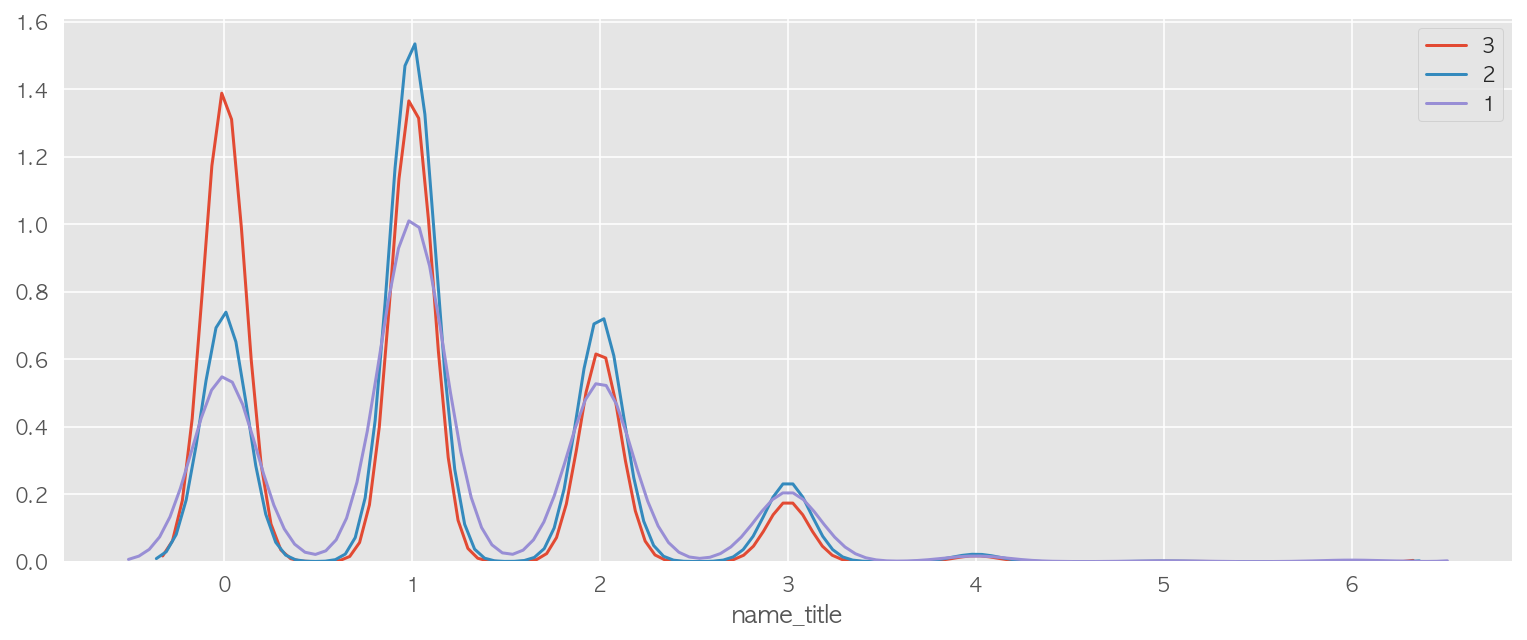

In [46]:
# 이 name_title은 상당히 중요한 자료라고 할 수 있다(좋은 변수)
# 일정하지 않고 / 오히려 상관관계가 0인경우 더 3번으로 갈 수 있다는 사실이 매우 흥미롭다
# 이렇게 대세를 바꿀수 있는 예외의 변수를 만드는 컬럼 및 조건들이 매우 중요함 -> 투입시킨다 
relevance3 = train.loc[train["relevance"] == 3]
relevance2 = train.loc[train["relevance"] == 2]
relevance1 = train.loc[train["relevance"] == 1]

plt.figure(figsize = [13,5])
ax1 =sns.distplot(relevance3["name_title"], hist = False, label = "3")
ax1 =sns.distplot(relevance2["name_title"], hist = False, label = "2")
ax1 =sns.distplot(relevance1["name_title"], hist = False, label = "1")
#ax1 =sns.distplot(relevance1_2["term_vlaue"], hist = False, label = "1~2")


## 6)name_description분석

name_description과 name_title을 분석해서 보면 그 중요성이 name_title이 좀더 많다 
* 그렇기 때문에 name_title을 변수로 두고 name_description은 빼주는게 좋으나 name_description에서 볼 수있는 다른 변수는 반드시 넣어주는 것이 좋다
* 그래프 결과 상관관계가 0인경우 더 3번으로 갈 수 있기에 이를 별도로 처리해준다 

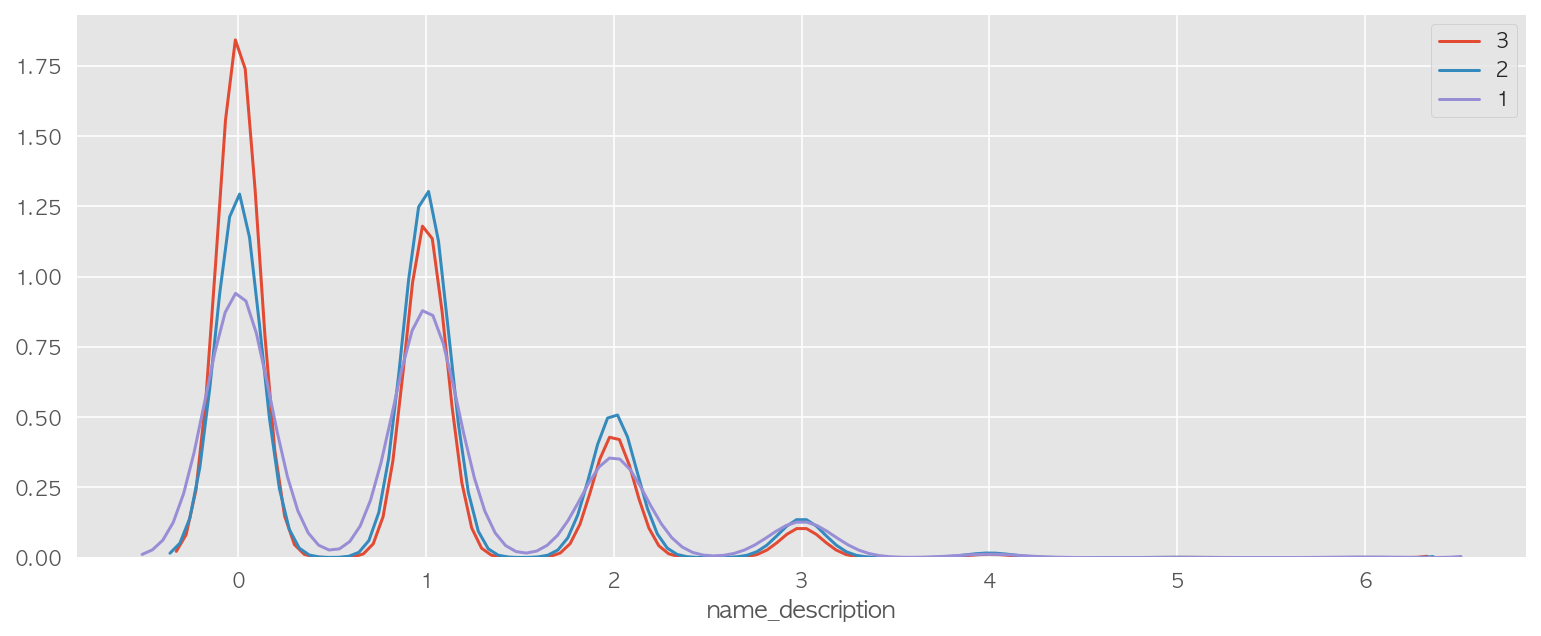

In [47]:
relevance3 = train.loc[train["relevance"] == 3]
relevance2 = train.loc[train["relevance"] == 2]
relevance1 = train.loc[train["relevance"] == 1]

plt.figure(figsize = [13,5])
ax1 =sns.distplot(relevance3["name_description"], hist = False, label = "3")
ax1 =sns.distplot(relevance2["name_description"], hist = False, label = "2")
ax1 =sns.distplot(relevance1["name_description"], hist = False, label = "1")
#ax1 =sns.distplot(relevance1_2["term_vlaue"], hist = False, label = "1~2")

In [48]:
train["name_description_0"] = train["name_description"] == 0
test["name_description_0"] = test["name_description"] == 0
train.head()

,product_uid,product_title,search_term,product_description,value,relevance,product_title(fix),search_term(fix),product_description(fix),value(fix),term_title_description,search_term(int),product_description(int),product_title(int),value(int),term_title,term_description,term_vlaue,name_title,name_description,number,false_true,name_description_0
0,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,"Not only do angles make joints stronger, they ...",Simpson Strong-Tie,3.00,simpson strong-ti 12-gaug angl,angl bracket,"not onli do angl make joint stronger, they als...",simpson strong-ti,angl bracket\tsimpson strong-ti 12-gaug angl\t...,2,129,4,2,1,1,0,2,2,False,True,False
2,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,BEHR Premium Textured DECKOVER is an innovativ...,BEHR Premium Textured DeckOver,3.00,behr premium textur deckov 1-gal. #sc-141 tugb...,deck over,behr premium textur deckov is an innov solid c...,behr premium textur deckov,deck over\tbehr premium textur deckov 1-gal. #...,2,167,11,4,1,1,1,4,4,False,True,False
3,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,Update your bathroom with the Delta Vero Singl...,Delta,2.33,delta vero 1-handl shower onli faucet trim kit...,rain shower head,updat your bathroom with the delta vero single...,delta,rain shower head\tdelta vero 1-handl shower on...,3,104,13,1,1,1,0,1,1,False,True,False
4,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,Update your bathroom with the Delta Vero Singl...,Delta,2.67,delta vero 1-handl shower onli faucet trim kit...,shower onli faucet,updat your bathroom with the delta vero single...,delta,shower onli faucet\tdelta vero 1-handl shower ...,3,104,13,1,3,2,0,1,1,True,True,False
5,100006,Whirlpool 1.9 cu. ft. Over the Range Convectio...,convection otr,Achieving delicious results is almost effortle...,Whirlpool,3.00,whirlpool 1.9 cu. ft. over the rang convect mi...,convect otr,achiev delici result is almost effortless with...,whirlpool,convect otr\twhirlpool 1.9 cu. ft. over the ra...,2,490,15,1,1,2,0,1,1,True,True,False


## 7)product_description

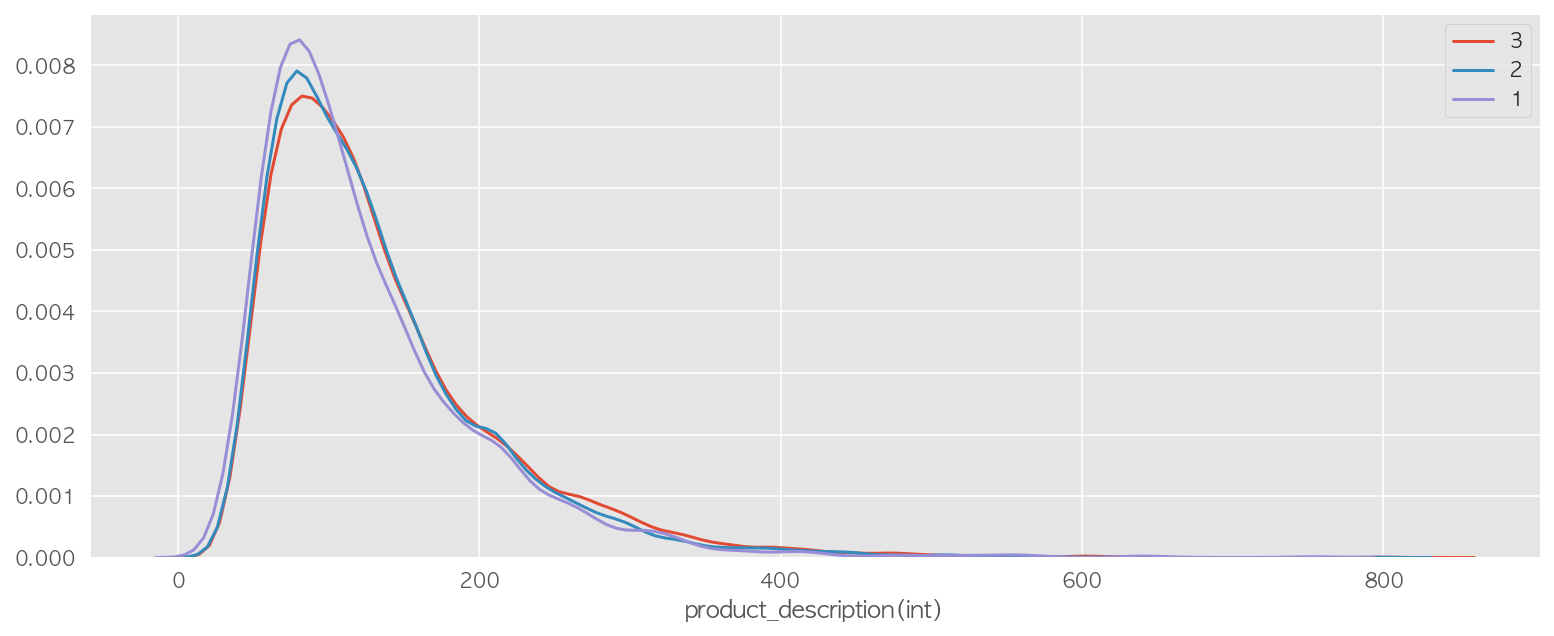

In [49]:
# 그래프 결과 별로 의미가 안보임 같은 방향이고 다른 변수가 없다는 점에서 제외해도 무방하다


relevance3 = train.loc[train["relevance"] == 3]
relevance2 = train.loc[train["relevance"] == 2]
relevance1 = train.loc[train["relevance"] == 1]
relevance1_2 = train.loc[train["relevance"] < 2]

plt.figure(figsize = [13,5])
ax1 =sns.distplot(relevance3["product_description(int)"], hist = False, label = "3")
ax1 =sns.distplot(relevance2["product_description(int)"], hist = False, label = "2")
ax1 =sns.distplot(relevance1["product_description(int)"], hist = False, label = "1")
#ax1 =sns.distplot(relevance1_2["product_description(int)"], hist = False, label = "1~2")


## 8)value(int)

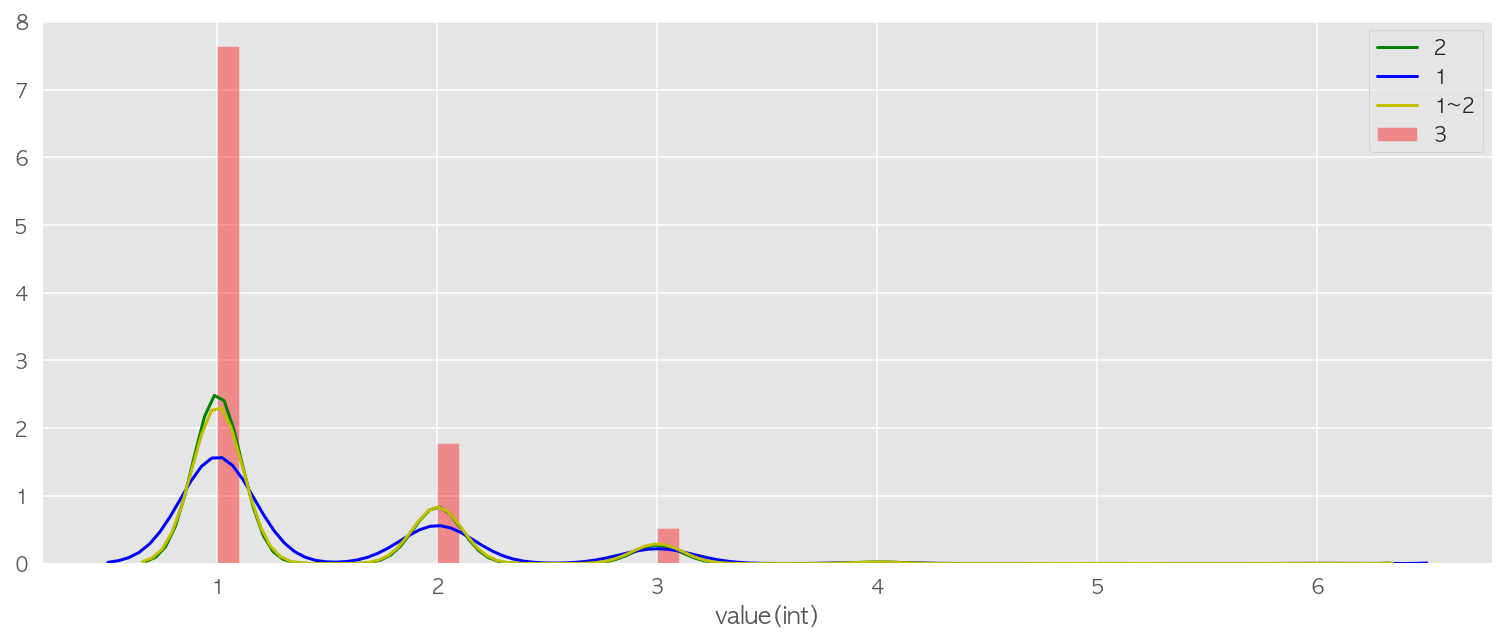

In [91]:
# value(int)는 이처럼 변수를 만들 수 있는 존재로서 분석 시 쓰여야 한다
relevance3 = train.loc[train["relevance"] == 3]
relevance2 = train.loc[train["relevance"] == 2]
relevance1 = train.loc[train["relevance"] == 1]
relevance1_2 = train.loc[train["relevance"] < 2]

plt.figure(figsize = [13,5])
ax1 =sns.distplot(relevance3["value(int)"], label = "3", color= "R")
ax1 =sns.distplot(relevance2["value(int)"], hist = False, label = "2", color= "G")
ax1 =sns.distplot(relevance1["value(int)"], hist = False, label = "1", color= "B")
ax1 =sns.distplot(relevance1_2["value(int)"], hist = False, label = "1~2", color= "Y")

**그래프 결과 그래프결과값이 다름**

relevance = 3인 경우 / value(int)가 상대적으로 높아짐을 알 수 있다 

* 브랜드네임의 길이수가 1인경우, 여러가지 이유로 인하여 relevance 1쪽으로 많이 몰려있다 
* 브랜드네임이 단 한개라면, 2~3개인 상황보다는 고객이 즉각적으로 원하는 결과를 가져오기 어렵다는 점이 있고(그만큼 검사범위가 넓어지는 결과를 만든다)
* 그래서 2개 이상인 경우에 relevance 3인 경우가 많다고 봐야한다

* 단 그래프에서 볼 수 있듯이 검색의 전체적인 범위(혹은 넓이)가 2,3은 매우 좁다 
* 이는 지금 이 데이터에서 고객이 검색한 대부분의 브랜드네임이 1개이고 2개이상은 상대적으로 적다는 것을 의미한다고 볼 수 있다
* homedepot에서는 이 자료를 보면서 1개 브랜드네임에 대한 검색의 조건을 강화할 필요성이 있다는 생각이 든다 


In [52]:
# train.loc[(train["value(int)"] == 2)|(train["value(int)"] == 3), "name_23"] = True
# train.loc[~((train["value(int)"] == 2)|(train["value(int)"] == 3)), "name_23"] = False
# train#.head()

# test.loc[(test["value(int)"] == 2)|(test["value(int)"] == 3), "name_23"] = True
# test.loc[~((test["value(int)"] == 2)|(test["value(int)"] == 3)), "name_23"] = False
# test#.head()

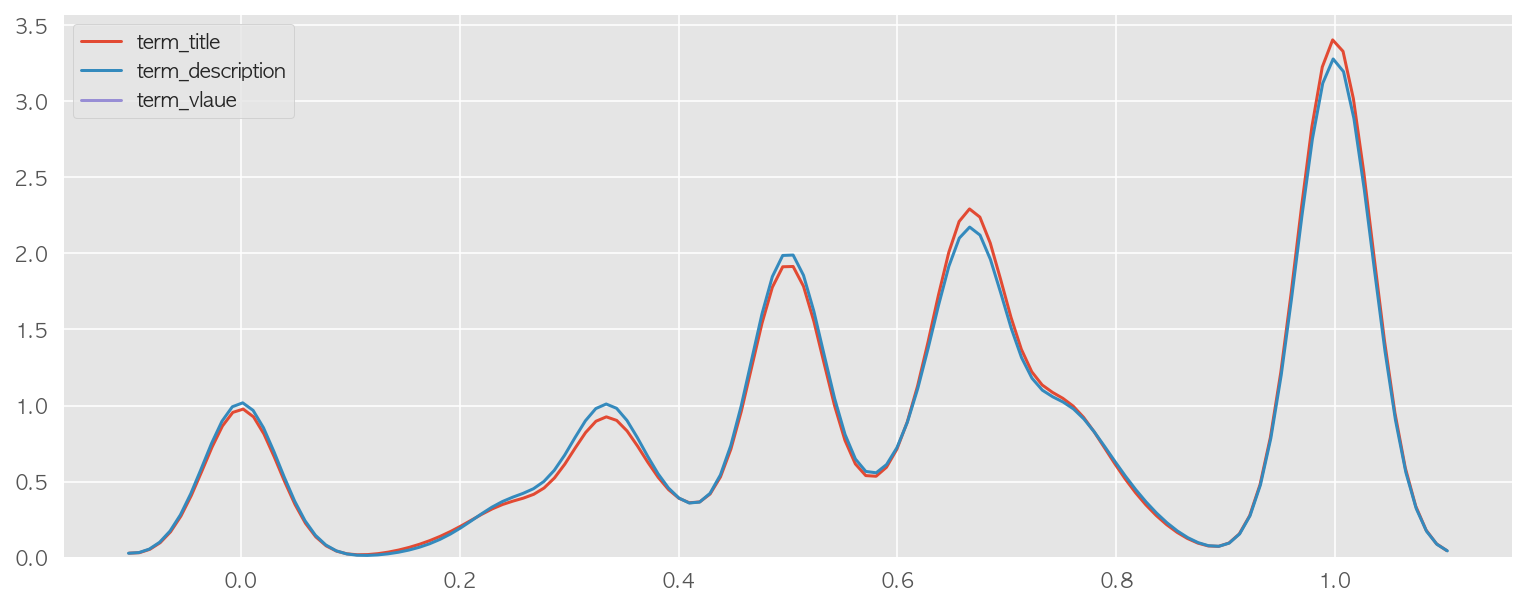

In [53]:
ratio = train["term_title"] / train["search_term(int)"]
ratio2 = train["term_description"] / train["search_term(int)"]
ratio3 = train["term_vlaue"] / train["search_term(int)"]

plt.figure(figsize = [13,5])
ax1 =sns.distplot(ratio, hist = False, label = "term_title")
ax1 =sns.distplot(ratio2, hist = False, label = "term_description")
ax1 =sns.distplot(ratio3, hist = False, label = "term_vlaue")

# preparation -check

In [58]:
feature_name=["product_uid","search_term(int)","product_title(int)","term_title","term_description",\
              "name_title","term_vlaue","number","name_description_0","value(int)"]
label_name="relevance"

In [59]:
x_train=train[feature_name]
y_train=train[label_name]
x_test=test[feature_name]

In [60]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators = 10, random_state = 37, n_jobs = -1)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=37, verbose=0, warm_start=False)

In [61]:
from sklearn.model_selection import cross_val_predict
y_prediction=cross_val_predict(model,x_train,y_train,cv=20)
y_prediction

array([1.932 , 2.099 , 2.7835, ..., 1.866 , 2.    , 2.    ])

In [62]:
from sklearn.metrics import mean_absolute_error
predict=mean_absolute_error(y_train,y_prediction)
predict

0.4251114314671609

In [63]:
from sklearn.metrics import mean_squared_error
predict=mean_squared_error(y_train,y_prediction)
predict

0.2849714167008931

In [64]:
from sklearn.metrics import mean_squared_log_error
predict=mean_squared_log_error(y_train,y_prediction)
predict

0.029253597830551398

# preparation - application

In [65]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor()
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [66]:
from sklearn.metrics import make_scorer

def rmle(predict,actual):
    predict=np.array(predict)
    actual=np.array(actual)
    distance=(predict-actual)**2
    score=distance.mean()
    return score

scorer=make_scorer(rmle)
scorer

make_scorer(rmle)

In [67]:
from sklearn.model_selection import cross_val_score

n_estimators= 10
search=10
hyperparameters_list=[]

for x in range(search):
    max_depth=np.random.randint(low=1,high=10)
    max_features=np.random.uniform(low=0.1,high=1.0)
    
    model=RandomForestRegressor(n_jobs = -1,random_state = 37,n_estimators = n_estimators, max_depth = max_depth,
                                max_features = max_features)
    score=cross_val_score(model,x_train,y_train,cv=20,scoring=scorer).mean()
    
    hyperparameters={"score":score,"n_estimators":n_estimators,"max_depth":max_depth,"max_features":max_features}
    hyperparameters_list.append(hyperparameters)
    print(f'n_estimators={n_estimators},score={score},max_depth={max_depth:.6f},max_features={max_features:.6f}') 

n_estimators=10,score=0.25592772189244073,max_depth=3.000000,max_features=0.202400
n_estimators=10,score=0.24562026987761643,max_depth=3.000000,max_features=0.349678
n_estimators=10,score=0.2600428527903682,max_depth=1.000000,max_features=0.805996
n_estimators=10,score=0.23472228016988783,max_depth=6.000000,max_features=0.863454
n_estimators=10,score=0.2329598727264056,max_depth=9.000000,max_features=0.958032
n_estimators=10,score=0.23692974857713325,max_depth=5.000000,max_features=0.934192
n_estimators=10,score=0.2326639126201199,max_depth=9.000000,max_features=0.537019
n_estimators=10,score=0.24342022909860628,max_depth=3.000000,max_features=0.581015
n_estimators=10,score=0.23621848244683202,max_depth=5.000000,max_features=0.819127
n_estimators=10,score=0.2325326914304072,max_depth=9.000000,max_features=0.778524


In [68]:
hyperparameters_list=pd.DataFrame.from_dict(hyperparameters_list)
hyperparameters_list=hyperparameters_list.sort_values(by="score")
hyperparameters_list.head(10)
hyperparameters_list.iloc[0]

max_depth        9.000000
max_features     0.778524
n_estimators    10.000000
score            0.232533
Name: 9, dtype: float64

# outperformance

In [69]:
# n_estimators를 1000번 돌린 결과 최적의 max_depth / max_features는 밑과 같음

from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_jobs= -1,n_estimators= 1000,random_state=37,max_depth = 9.0, max_features = 0.997677)
model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9.0,
           max_features=0.997677, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=37, verbose=0, warm_start=False)

In [70]:
model.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9.0,
           max_features=0.997677, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=37, verbose=0, warm_start=False)

In [71]:
prediction=model.predict(x_test)

In [72]:
submission=pd.read_csv("Desktop/phthon/kaggle/homedepot/sample_submission.csv",index_col=["id"])
print(submission.shape)
submission.head()

(166693, 1)


,relevance
id,
1,1
4,1
5,1
6,1
7,1


In [73]:
submission["relevance"]=prediction

submission.head()

,relevance
id,
1,2.023466
4,2.205135
5,2.205413
6,2.329603
7,2.178859


In [74]:
submission.to_csv("Desktop/phthon/kaggle/homedepot/final.csv")